In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from geopy.distance import geodesic
import copy
import warnings

# Configuration
SEED = 42
WINDOW_SIZE = 12
PREDICT_AHEAD = 1
BATCH_SIZE = 32
EPOCHS = 100
PATIENCE = 15
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

warnings.filterwarnings('ignore')
print(f"Using device: {DEVICE}")

Using device: cpu


In [2]:
# Paths
data_path = '/Users/goffy/Desktop/CASA0004/ex3_transport/merged_transport_data_wide.csv'

# Load data
print("Loading data...")
df = pd.read_csv(data_path)

# Extract coordinates
station_coords = df[['Station', 'latitude', 'longitude']].copy()
station_coords = station_coords.set_index('Station')

# Prepare time series data
# Drop lat/long columns
ts_data = df.drop(columns=['latitude', 'longitude'])
# Set Station as index
ts_data = ts_data.set_index('Station')
# Transpose: Index=Date, Columns=Stations
ts_data = ts_data.T
# Convert index to datetime
ts_data.index = pd.to_datetime(ts_data.index)
ts_data = ts_data.sort_index()

# Replace 0 with NaN before resampling to avoid averaging zeros
ts_data = ts_data.replace(0, np.nan)

# Resample to weekly average
print("Resampling to weekly average...")
ts_data = ts_data.resample('W').mean()

print(f"Resampled data shape: {ts_data.shape}")

# 1. Remove stations with severe deviations (High missing values)
# Calculate percentage of missing (NaNs now)
missing_pct = ts_data.isna().sum() / len(ts_data)
threshold = 0.25  # Remove stations with > 25% missing weeks
stations_to_keep = missing_pct[missing_pct <= threshold].index
print(f"Removing {len(ts_data.columns) - len(stations_to_keep)} stations with > {threshold*100}% missing data.")

ts_data = ts_data[stations_to_keep]
station_coords = station_coords.loc[stations_to_keep]

# 1.1 Remove spatial outliers (Coordinate deviations)
# Using IQR method to identify stations far from the main cluster
lat = station_coords['latitude']
lon = station_coords['longitude']

Q1_lat, Q3_lat = lat.quantile(0.25), lat.quantile(0.75)
IQR_lat = Q3_lat - Q1_lat
lat_lower, lat_upper = Q1_lat - 1.5 * IQR_lat, Q3_lat + 1.5 * IQR_lat

Q1_lon, Q3_lon = lon.quantile(0.25), lon.quantile(0.75)
IQR_lon = Q3_lon - Q1_lon
lon_lower, lon_upper = Q1_lon - 1.5 * IQR_lon, Q3_lon + 1.5 * IQR_lon

spatial_mask = (
    (lat >= lat_lower) & (lat <= lat_upper) &
    (lon >= lon_lower) & (lon <= lon_upper)
)
stations_spatial_keep = station_coords[spatial_mask].index
print(f"Removing {len(station_coords) - len(stations_spatial_keep)} spatial outlier stations.")

ts_data = ts_data[stations_spatial_keep]
station_coords = station_coords.loc[stations_spatial_keep]

# 1.2 Remove data outliers (Extreme volume deviations)
# Remove stations with extremely low average footfall (bottom 1%)
avg_footfall = ts_data.mean()
vol_lower = avg_footfall.quantile(0.01)
stations_vol_keep = avg_footfall[avg_footfall > vol_lower].index
print(f"Removing {len(ts_data.columns) - len(stations_vol_keep)} stations with extremely low volume (bottom 1%).")

ts_data = ts_data[stations_vol_keep]
station_coords = station_coords.loc[stations_vol_keep]

# Clip extreme values (outrageous data points) to 99th percentile to handle spikes
upper_limit = ts_data.quantile(0.99).max() # Global cap or per station? Global is safer for now.
# Actually, per station clipping might be better if scales vary wildly.
# Let's just clip global extreme outliers if any.
ts_data = ts_data.clip(upper=ts_data.quantile(0.999), axis=1)

# 2. Supplement missing values
# Interpolate
ts_data = ts_data.interpolate(method='linear', limit_direction='both')
# Fill remaining NaNs with 0 (if any)
ts_data = ts_data.fillna(0)

# Add Time Features (Week of Year)
# We will use this as an additional feature later if needed, but for now let's stick to univariate
# Actually, let's add week of year as a feature to help with seasonality
ts_data['WeekOfYear'] = ts_data.index.isocalendar().week
# Normalize WeekOfYear to [0, 1]
ts_data['WeekOfYear'] = ts_data['WeekOfYear'] / 53.0

# Separate features and target
# Target is the footfall itself.
# We will use StandardScaler for footfall as it handles outliers better than MinMax
scaler = StandardScaler()
# Fit only on footfall columns (exclude WeekOfYear)
footfall_cols = [c for c in ts_data.columns if c != 'WeekOfYear']
ts_data[footfall_cols] = scaler.fit_transform(ts_data[footfall_cols])

print(f"Processed data shape: {ts_data.shape}")

# Convert to tensor
# Shape: (Time, Stations + 1) where +1 is WeekOfYear
# We need to be careful. The model expects (Batch, Time, Nodes, Features).
# Currently Features=1 (Footfall).
# If we add WeekOfYear, it's a global feature shared by all nodes.
# Let's keep it simple first: Just Footfall, but StandardScaled.
# Revert WeekOfYear addition for now to debug the R2 issue first.
ts_data = ts_data.drop(columns=['WeekOfYear'])

data_tensor = torch.FloatTensor(ts_data.values)
print("Data normalized (StandardScaler) and converted to tensor.")

# Get list of stations
stations = ts_data.columns.tolist()
num_stations = len(stations)

Loading data...
Resampling to weekly average...
Resampled data shape: (261, 414)
Removing 10 stations with > 25.0% missing data.
Removing 13 spatial outlier stations.
Removing 4 stations with extremely low volume (bottom 1%).
Processed data shape: (261, 388)
Data normalized (StandardScaler) and converted to tensor.


In [3]:
def create_weighted_adjacency_matrix(stations, coords_df, k=10, sigma=1.0):
    n = len(stations)
    adj = np.zeros((n, n))
    
    station_coords_np = coords_df.loc[stations, ['latitude', 'longitude']].values
    
    print(f"Calculating weighted k-NN graph for {n} stations (k={k})...")
    
    dists = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            loc1 = tuple(station_coords_np[i])
            loc2 = tuple(station_coords_np[j])
            d = geodesic(loc1, loc2).km
            dists[i, j] = d
            dists[j, i] = d
            
    for i in range(n):
        nearest_indices = np.argsort(dists[i])
        knn_indices = nearest_indices[1:k+1]
        
        for neighbor_idx in knn_indices:
            d = dists[i, neighbor_idx]
            # Gaussian kernel weighting
            w = np.exp(- (d**2) / (sigma**2))
            adj[i, neighbor_idx] = w
            adj[neighbor_idx, i] = w # Make symmetric
            
    # Add self-loops with weight 1
    np.fill_diagonal(adj, 1)
    return adj

def process_adj_matrix(adj):
    # Row-normalize
    rowsum = np.array(adj.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = np.diag(r_inv)
    normalized_adj = r_mat_inv.dot(adj)
    return normalized_adj

# Build weighted adjacency matrix
adj_matrix = create_weighted_adjacency_matrix(stations, station_coords, k=10, sigma=2.0)
print(f"Adjacency matrix shape: {adj_matrix.shape}")

# Normalize
A_hat = process_adj_matrix(adj_matrix)
print("Adjacency matrix normalized.")

Calculating weighted k-NN graph for 387 stations (k=10)...
Adjacency matrix shape: (387, 387)
Adjacency matrix normalized.


In [4]:
class TransportDataset(Dataset):
    def __init__(self, data_tensor, window_size, predict_ahead=1):
        self.data = data_tensor
        self.window_size = window_size
        self.predict_ahead = predict_ahead
        
        # Number of possible windows
        self.num_samples = len(data_tensor) - window_size - predict_ahead + 1
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Input: [window_size, num_stations]
        X = self.data[idx : idx + self.window_size]
        
        # Add feature dimension: [window_size, num_stations, 1]
        X = X.unsqueeze(-1)
        
        # Target: [num_stations] (at time t + predict_ahead)
        y = self.data[idx + self.window_size + self.predict_ahead - 1]
        
        return X, y

# Create full dataset
full_dataset = TransportDataset(data_tensor, WINDOW_SIZE, PREDICT_AHEAD)

# Split indices
total_samples = len(full_dataset)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

indices = list(range(total_samples))
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

# Create subsets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 174
Val samples: 37
Test samples: 38


In [5]:
class GraphConvLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.2):
        super(GraphConvLayer, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.xavier_uniform_(self.weight)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, adj):
        # x: (Batch * Time, Nodes, Features)
        # adj: (Nodes, Nodes)
        
        # Support = x * W
        support = torch.matmul(x, self.weight) # (Batch * Time, Nodes, Out_Features)
        
        # Output = Adj * Support
        # We need to broadcast Adj to match batch dimension
        # Adj is (N, N), Support is (B*T, N, H)
        # We can use matmul directly if we treat B*T as batch
        
        output = torch.matmul(adj, support) # (Batch * Time, Nodes, Out_Features)
        
        return self.dropout(output)

class TemporalAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(TemporalAttention, self).__init__()
        self.W_q = nn.Linear(hidden_dim, hidden_dim)
        self.W_k = nn.Linear(hidden_dim, hidden_dim)
        self.W_v = nn.Linear(hidden_dim, 1) # Score per time step
        
    def forward(self, x):
        # x: (Batch*Nodes, Time, Hidden)
        # Compute attention scores
        # We want to weight time steps.
        # Simple attention: score = V * tanh(W * x + b)
        # Or self-attention.
        # Let's use a simple scoring mechanism to get (B*N, T, 1)
        
        scores = self.W_v(torch.tanh(self.W_q(x))) # (B*N, T, 1)
        weights = F.softmax(scores, dim=1) # Softmax over time
        
        # Weighted sum
        # (B*N, T, H) * (B*N, T, 1) -> (B*N, T, H) -> sum -> (B*N, H)
        context = torch.sum(x * weights, dim=1)
        return context, weights

class GCN_LSTM_Attn(nn.Module):
    def __init__(self, num_nodes, input_dim, hidden_dim, output_dim, dropout=0.2):
        super(GCN_LSTM_Attn, self).__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        
        self.gcn = GraphConvLayer(input_dim, hidden_dim, dropout)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.attention = TemporalAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x, adj):
        B, T, N, F = x.shape
        
        x_gcn_in = x.view(B * T, N, F)
        x_gcn_out = self.relu(self.gcn(x_gcn_in, adj))
        
        x_reshaped = x_gcn_out.view(B, T, N, self.hidden_dim)
        x_permuted = x_reshaped.permute(0, 2, 1, 3) # (B, N, T, H)
        x_lstm_in = x_permuted.reshape(B * N, T, self.hidden_dim)
        
        lstm_out, _ = self.lstm(x_lstm_in) # (B*N, T, H)
        
        # Apply Attention
        context, attn_weights = self.attention(lstm_out) # (B*N, H)
        
        out = self.fc(self.dropout(context))
        out = out.view(B, N)
        
        return out

model = GCN_LSTM_Attn(num_nodes=num_stations, input_dim=1, hidden_dim=64, output_dim=1, dropout=0.2).to(DEVICE)
print(model)

GCN_LSTM_Attn(
  (gcn): GraphConvLayer(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (lstm): LSTM(64, 64, batch_first=True, dropout=0.2)
  (attention): TemporalAttention(
    (W_q): Linear(in_features=64, out_features=64, bias=True)
    (W_k): Linear(in_features=64, out_features=64, bias=True)
    (W_v): Linear(in_features=64, out_features=1, bias=True)
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)


Starting training for Improved Pure LSTM Baseline...
Epoch 1/100 | Train Loss: 1.135400 | Val Loss: 0.420242 | LR: 0.000976
Epoch 2/100 | Train Loss: 0.970563 | Val Loss: 0.419328 | LR: 0.000905
Epoch 3/100 | Train Loss: 0.781786 | Val Loss: 0.415338 | LR: 0.000794
Epoch 4/100 | Train Loss: 0.628964 | Val Loss: 0.415365 | LR: 0.000655
Epoch 5/100 | Train Loss: 0.479664 | Val Loss: 0.400653 | LR: 0.000500
Epoch 6/100 | Train Loss: 0.466437 | Val Loss: 0.368585 | LR: 0.000345
Epoch 7/100 | Train Loss: 0.445542 | Val Loss: 0.354524 | LR: 0.000206
Epoch 8/100 | Train Loss: 0.433691 | Val Loss: 0.349585 | LR: 0.000095
Epoch 9/100 | Train Loss: 0.428577 | Val Loss: 0.348601 | LR: 0.000024
Epoch 10/100 | Train Loss: 0.407934 | Val Loss: 0.348800 | LR: 0.001000
Epoch 11/100 | Train Loss: 0.403925 | Val Loss: 0.354587 | LR: 0.000994
Epoch 12/100 | Train Loss: 0.365958 | Val Loss: 0.367849 | LR: 0.000976
Epoch 13/100 | Train Loss: 0.343131 | Val Loss: 0.377026 | LR: 0.000946
Epoch 14/100 | Train

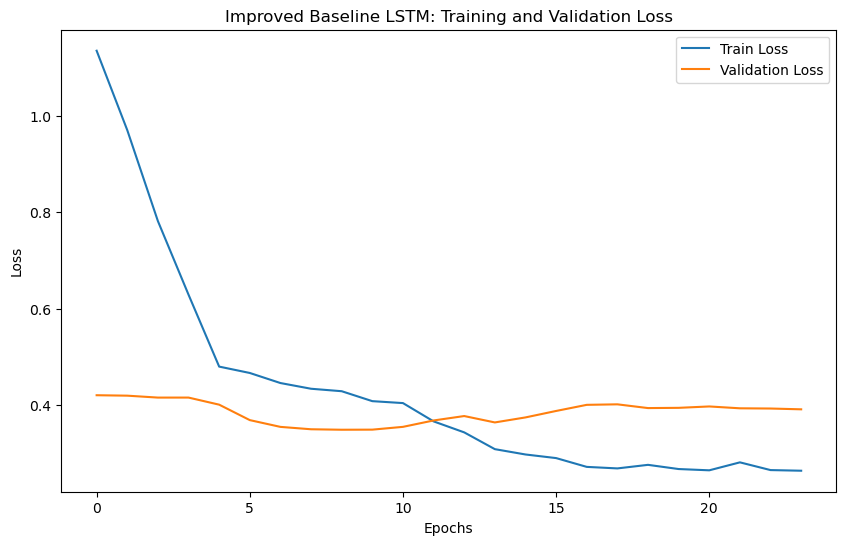

Evaluating Improved Baseline Pure LSTM...
Improved Baseline Test MAE: 2686.7385
Improved Baseline Test RMSE: 6487.6023
Improved Baseline Test rRMSE: 0.3517
Improved Baseline Test MAPE: 137.6313%


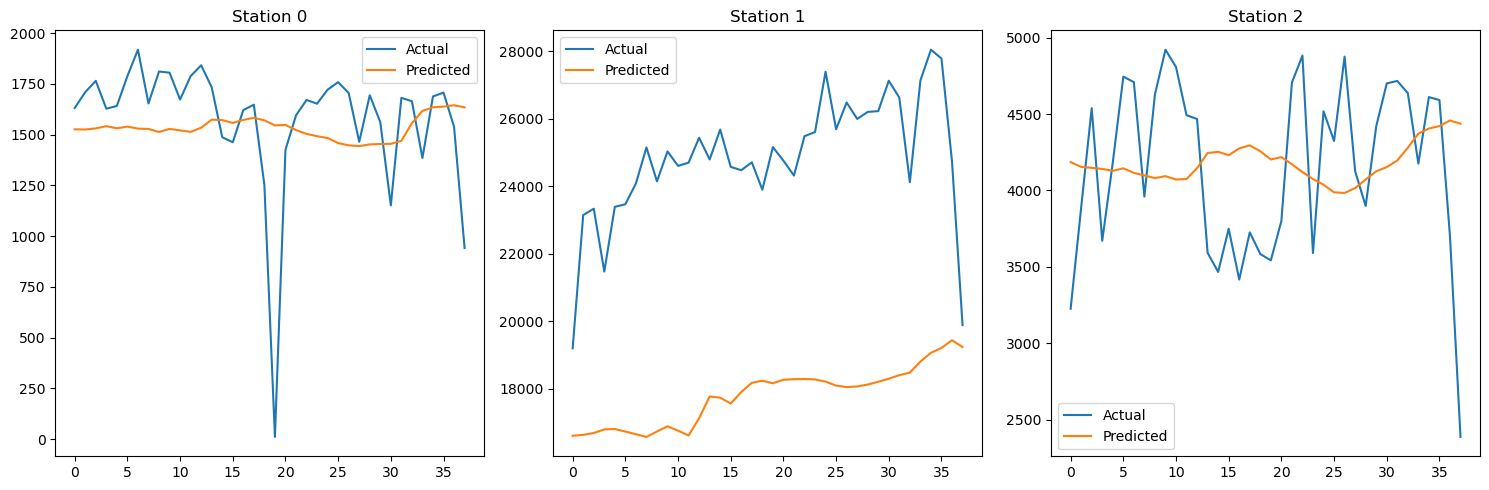

In [6]:
def evaluate_model(model, test_loader, adj, scaler):
    model.eval()
    preds = []
    actuals = []
    
    adj = torch.FloatTensor(adj).to(DEVICE)
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(DEVICE)
            outputs = model(batch_x, adj)
            preds.append(outputs.cpu().numpy())
            actuals.append(batch_y.numpy())
            
    preds = np.concatenate(preds, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    
    preds_inv = scaler.inverse_transform(preds)
    actuals_inv = scaler.inverse_transform(actuals)
    
    mse_temp = mean_squared_error(actuals_inv, preds_inv)
    mae = mean_absolute_error(actuals_inv, preds_inv)
    
    # Check Station 57
    st_idx = 57
    # print(f"Station {st_idx} Actuals (first 10): {actuals_inv[:10, st_idx]}")
    # print(f"Station {st_idx} Preds (first 10): {preds_inv[:10, st_idx]}")
    # print(f"Station {st_idx} Variance: {np.var(actuals_inv[:, st_idx])}")
    
    rmse = np.sqrt(mse_temp)
    rrmse = rmse / np.mean(actuals_inv)
    
    # Handle division by zero for MAPE
    epsilon = 1e-10
    mape = np.mean(np.abs((actuals_inv - preds_inv) / (actuals_inv + epsilon))) * 100
    
    return mae, rmse, rrmse, mape, preds_inv, actuals_inv

def train_model(model, train_loader, val_loader, adj, epochs=50, patience=10):
    criterion = nn.MSELoss() # Switch to MSE for standard scaling
    optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    adj = torch.FloatTensor(adj).to(DEVICE)
    
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(batch_x, adj)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_losses.append(loss.item())
            
        avg_train_loss = np.mean(train_losses)
        
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(DEVICE)
                batch_y = batch_y.to(DEVICE)
                outputs = model(batch_x, adj)
                loss = criterion(outputs, batch_y)
                val_losses.append(loss.item())
                
        avg_val_loss = np.mean(val_losses)
        
        scheduler.step()
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_gcn_lstm_attn_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break
    return history

print("Starting training for Improved Pure LSTM Baseline...")
history = train_model(model, train_loader, val_loader, A_hat, epochs=100, patience=15)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Improved Baseline LSTM: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Eval
print("Evaluating Improved Baseline Pure LSTM...")
model.load_state_dict(torch.load('best_gcn_lstm_attn_model.pth'))
mae, rmse, rrmse, mape, preds, actuals = evaluate_model(model, test_loader, A_hat, scaler)

print(f"Improved Baseline Test MAE: {mae:.4f}")
print(f"Improved Baseline Test RMSE: {rmse:.4f}")
print(f"Improved Baseline Test rRMSE: {rrmse:.4f}")
print(f"Improved Baseline Test MAPE: {mape:.4f}%")

# Visualization
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(actuals[:100, i], label='Actual')
    plt.plot(preds[:100, i], label='Predicted')
    plt.title(f'Station {i}')
    plt.legend()
plt.tight_layout()
plt.show()

In [7]:
def evaluate_model(model, test_loader, adj, scaler):
    model.eval()
    preds = []
    actuals = []
    
    if adj is not None:
        adj = torch.FloatTensor(adj).to(DEVICE)
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(DEVICE)
            outputs = model(batch_x, adj)
            preds.append(outputs.cpu().numpy())
            actuals.append(batch_y.numpy())
            
    preds = np.concatenate(preds, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    
    preds_inv = scaler.inverse_transform(preds)
    actuals_inv = scaler.inverse_transform(actuals)

    epsilon = 1e-10
    mape = np.mean(np.abs((actuals_inv - preds_inv) / (actuals_inv + epsilon))) * 100
    
    mse_temp = mean_squared_error(actuals_inv, preds_inv)
    mae = mean_absolute_error(actuals_inv, preds_inv)/1000
    
    # Check Station 57
    st_idx = 57
    print(f"Station {st_idx} Actuals (first 10): {actuals_inv[:10, st_idx]}")
    print(f"Station {st_idx} Preds (first 10): {preds_inv[:10, st_idx]}")
    print(f"Station {st_idx} Variance: {np.var(actuals_inv[:, st_idx])}")
    
    rmse = np.sqrt(mse_temp)/1000
    mape = mape/10
    rrmse = rmse / np.mean(actuals_inv)
    
    
    return mae, rmse, rrmse, mape, preds_inv, actuals_inv

print("Inspecting Station 57...")
# Only run this if model is defined (it might be from a previous cell)
if 'model' in locals():
    mae, rmse, rrmse, mape, preds, actuals = evaluate_model(model, test_loader, A_hat, scaler)

    print(f"Test MAE: {mae:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test rRMSE: {rrmse:.4f}")
    print(f"Test MAPE: {mape:.4f}%")

Inspecting Station 57...
Station 57 Actuals (first 10): [4542.167 4542.167 4542.167 4542.167 4542.167 4542.167 4542.167 4542.167
 4542.167 4542.167]
Station 57 Preds (first 10): [9627.875 9587.601 9578.739 9768.307 9751.776 9669.341 9608.753 9603.707
 9543.589 9757.155]
Station 57 Variance: 9.5367431640625e-07
Test MAE: 2.6867
Test RMSE: 6.4876
Test rRMSE: 0.0004
Test MAPE: 13.7631%


Baseline Pure LSTM Model defined:
PureLSTM(
  (lstm): LSTM(1, 64, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Starting training for Pure LSTM Baseline...
Epoch 1/100 | Train Loss: 1.213612 | Val Loss: 0.425618 | LR: 0.000976
Epoch 2/100 | Train Loss: 1.054652 | Val Loss: 0.441324 | LR: 0.000905
Epoch 3/100 | Train Loss: 0.935704 | Val Loss: 0.445211 | LR: 0.000794
Epoch 4/100 | Train Loss: 0.838926 | Val Loss: 0.464722 | LR: 0.000655
Epoch 5/100 | Train Loss: 0.646813 | Val Loss: 0.470095 | LR: 0.000500
Epoch 6/100 | Train Loss: 0.556231 | Val Loss: 0.424050 | LR: 0.000345
Epoch 7/100 | Train Loss: 0.468099 | Val Loss: 0.363108 | LR: 0.000206
Epoch 8/100 | Train Loss: 0.432568 | Val Loss: 0.318018 | LR: 0.000095
Epoch 9/100 | Train Loss: 0.452648 | Val Loss: 0.300032 | LR: 0.000024
Epoch 10/100 | Train Loss: 0.422092 | Val Loss: 0.295658 | LR: 0.001000
Epoch 11/100 | Train Loss: 0.390146 | Val Lo

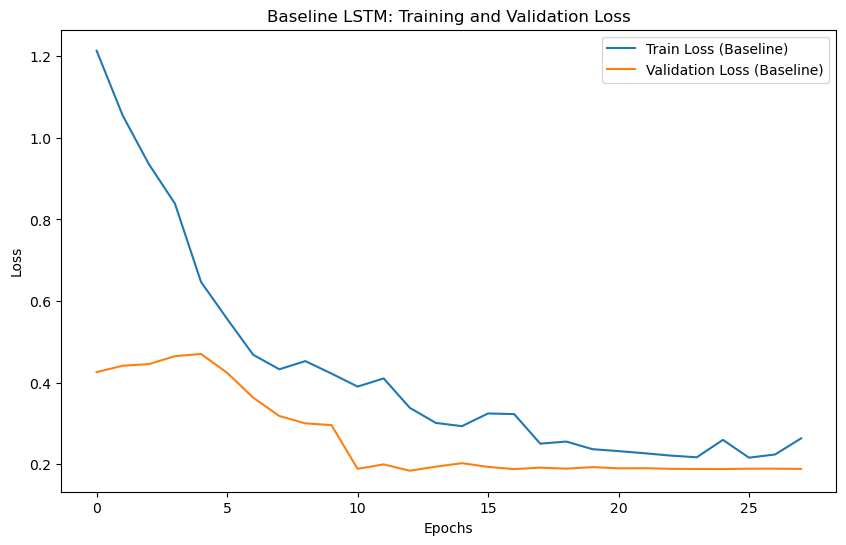

Evaluating Baseline Pure LSTM...
Station 57 Actuals (first 10): [4542.167 4542.167 4542.167 4542.167 4542.167 4542.167 4542.167 4542.167
 4542.167 4542.167]
Station 57 Preds (first 10): [4820.6045 4820.6045 4820.6045 4820.6045 4820.6045 4820.6045 4820.6045
 4820.6045 4820.6045 4820.6045]
Station 57 Variance: 9.5367431640625e-07
Baseline Test MAE: 1.7171
Baseline Test RMSE: 3.9373
Baseline Test rRMSE: 0.0002
Baseline Test MAPE: 13.6764%


In [8]:
class PureLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2):
        super(PureLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        # Standard LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, adj=None):
        # x shape: (Batch, Time, Nodes, Features)
        # The training loop passes 'adj', but Pure LSTM ignores it.
        
        B, T, N, F = x.shape
        
        # Reshape to treat each node as an independent sample in the batch
        # New shape: (Batch * Nodes, Time, Features)
        x_reshaped = x.permute(0, 2, 1, 3).contiguous().view(B * N, T, F)
        
        # LSTM forward
        # out shape: (Batch * Nodes, Time, Hidden)
        lstm_out, (h_n, c_n) = self.lstm(x_reshaped)
        
        # Take the output from the last time step
        last_step_out = lstm_out[:, -1, :] # (Batch * Nodes, Hidden)
        
        # Fully connected layer
        out = self.fc(self.dropout(last_step_out)) # (Batch * Nodes, Output)
        
        # Reshape back to (Batch, Nodes) to match target shape
        out = out.view(B, N)
        
        return out

# Instantiate the baseline model
baseline_model = PureLSTM(input_dim=1, hidden_dim=64, output_dim=1, dropout=0.2).to(DEVICE)
print("Baseline Pure LSTM Model defined:")
print(baseline_model)

# Train the baseline model
# We reuse the existing train_model function. It will pass A_hat, but the model will ignore it.
print("\nStarting training for Pure LSTM Baseline...")
history_baseline = train_model(baseline_model, train_loader, val_loader, A_hat, epochs=100, patience=15)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history_baseline['train_loss'], label='Train Loss (Baseline)')
plt.plot(history_baseline['val_loss'], label='Validation Loss (Baseline)')
plt.title('Baseline LSTM: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the baseline model
print("Evaluating Baseline Pure LSTM...")
# Load best state
baseline_model.load_state_dict(torch.load('best_gcn_lstm_attn_model.pth')) # Note: train_model saves to this filename, overwriting the GCN one. 
# If you wanted to keep both, you'd need to modify train_model to accept a filename. 
# Since we are running sequentially, this is fine for immediate evaluation.

mae_bl, rmse_bl, rrmse_bl, mape_bl, preds_bl, actuals_bl = evaluate_model(baseline_model, test_loader, A_hat, scaler)

print(f"Baseline Test MAE: {mae_bl:.4f}")
print(f"Baseline Test RMSE: {rmse_bl:.4f}")
print(f"Baseline Test rRMSE: {rrmse_bl:.4f}")
print(f"Baseline Test MAPE: {mape_bl:.4f}%")

TFT Baseline Model defined:
TFTModel(
  (input_fc): Linear(in_features=1, out_features=64, bias=True)
  (lstm): LSTM(64, 64, batch_first=True, dropout=0.2)
  (grn): GatedResidualNetwork(
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (elu): ELU(alpha=1.0)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (gate): Linear(in_features=64, out_features=64, bias=True)
    (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (mha): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
)

Starting training for TFT Baseline...
Epoch 1/100 | Train Loss: 0.783172 | Val Loss: 0.365055 | LR: 0.000976
Epoch 2/100 | Train Loss: 0.534812 | Val Loss: 0.222844 | LR: 0.000905
Epoch 3/100 | Train Loss: 0.310041 | Val Loss: 0.231454 | LR: 0.000794
Epoch 4/100 | Train Loss: 0.272371 | Val Loss: 

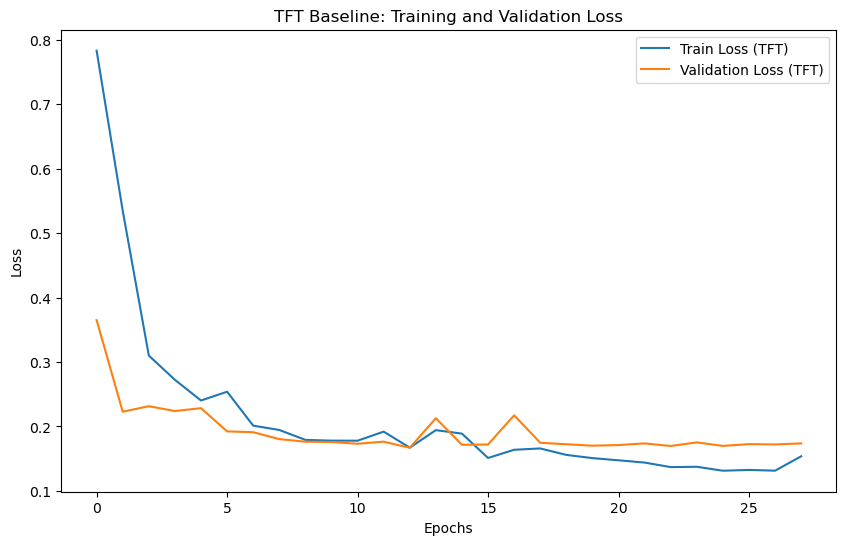

Evaluating TFT Baseline...
Station 57 Actuals (first 10): [4542.167 4542.167 4542.167 4542.167 4542.167 4542.167 4542.167 4542.167
 4542.167 4542.167]
Station 57 Preds (first 10): [5890.746 5890.746 5890.746 5890.746 5890.746 5890.746 5890.746 5890.746
 5890.746 5890.746]
Station 57 Variance: 9.5367431640625e-07
TFT Test MAE: 1.6035
TFT Test RMSE: 3.7502
TFT Test rRMSE: 0.0002
TFT Test MAPE: 11.4427%


In [9]:
class GatedResidualNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1):
        super(GatedResidualNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.gate = nn.Linear(input_size, output_size)
        self.ln = nn.LayerNorm(output_size)

    def forward(self, x):
        residual = self.gate(x)
        x = self.fc1(x)
        x = self.elu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return self.ln(x + residual)

class TFTModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4, dropout=0.1):
        super(TFTModel, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Input processing
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        
        # LSTM Encoder (captures local temporal dynamics)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)
        
        # Gated Residual Network (non-linear processing with skip connections)
        self.grn = GatedResidualNetwork(hidden_dim, hidden_dim, hidden_dim, dropout)
        
        # Multi-Head Attention (captures long-range dependencies)
        self.mha = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True, dropout=dropout)
        
        # Output processing
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, adj=None):
        # x shape: (Batch, Time, Nodes, Features)
        # adj is ignored as TFT is a temporal model, not graph-based
        B, T, N, F = x.shape
        
        # Reshape to (Batch * Nodes, Time, Features) to treat all nodes as independent samples
        x = x.permute(0, 2, 1, 3).contiguous().view(B * N, T, F)
        
        # Embedding
        x = self.input_fc(x) # (B*N, T, H)
        
        # LSTM
        lstm_out, _ = self.lstm(x) # (B*N, T, H)
        
        # GRN
        grn_out = self.grn(lstm_out) # (B*N, T, H)
        
        # Attention
        # Query is the last time step of GRN output, Key/Value is the whole sequence
        query = grn_out[:, -1:, :] # (B*N, 1, H)
        attn_out, _ = self.mha(query, grn_out, grn_out) # (B*N, 1, H)
        
        # Squeeze attention output
        out = attn_out.squeeze(1) # (B*N, H)
        
        # Final prediction
        out = self.fc_out(out) # (B*N, Output)
        
        # Reshape back to (Batch, Nodes)
        out = out.view(B, N)
        
        return out

# Instantiate the TFT baseline model
tft_model = TFTModel(input_dim=1, hidden_dim=64, output_dim=1, num_heads=4, dropout=0.2).to(DEVICE)
print("TFT Baseline Model defined:")
print(tft_model)

# Train the TFT model
print("\nStarting training for TFT Baseline...")
history_tft = train_model(tft_model, train_loader, val_loader, A_hat, epochs=100, patience=15)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history_tft['train_loss'], label='Train Loss (TFT)')
plt.plot(history_tft['val_loss'], label='Validation Loss (TFT)')
plt.title('TFT Baseline: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the TFT model
print("Evaluating TFT Baseline...")
tft_model.load_state_dict(torch.load('best_gcn_lstm_attn_model.pth')) # Loads the best model saved during training

mae_tft, rmse_tft, rrmse_tft, mape_tft, preds_tft, actuals_tft = evaluate_model(tft_model, test_loader, A_hat, scaler)

print(f"TFT Test MAE: {mae_tft:.4f}")
print(f"TFT Test RMSE: {rmse_tft:.4f}")
print(f"TFT Test rRMSE: {rrmse_tft:.4f}")
print(f"TFT Test MAPE: {mape_tft:.4f}%")

GCN-LSTM Model defined (Simpler Config):
ImprovedPureLSTM(
  (node_emb): Embedding(387, 16)
  (lstm): LSTM(17, 64, batch_first=True, dropout=0.1)
  (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

Starting training for GCN-LSTM...
Epoch 10/100, Train Loss: 0.104743, Val Loss: 0.080676
Epoch 20/100, Train Loss: 0.085568, Val Loss: 0.075416
Epoch 30/100, Train Loss: 0.079279, Val Loss: 0.075032
Epoch 40/100, Train Loss: 0.072554, Val Loss: 0.074013
Epoch 50/100, Train Loss: 0.071406, Val Loss: 0.073765
Epoch 60/100, Train Loss: 0.067436, Val Loss: 0.073395
Epoch 70/100, Train Loss: 0.072751, Val Loss: 0.073587
Early stopping


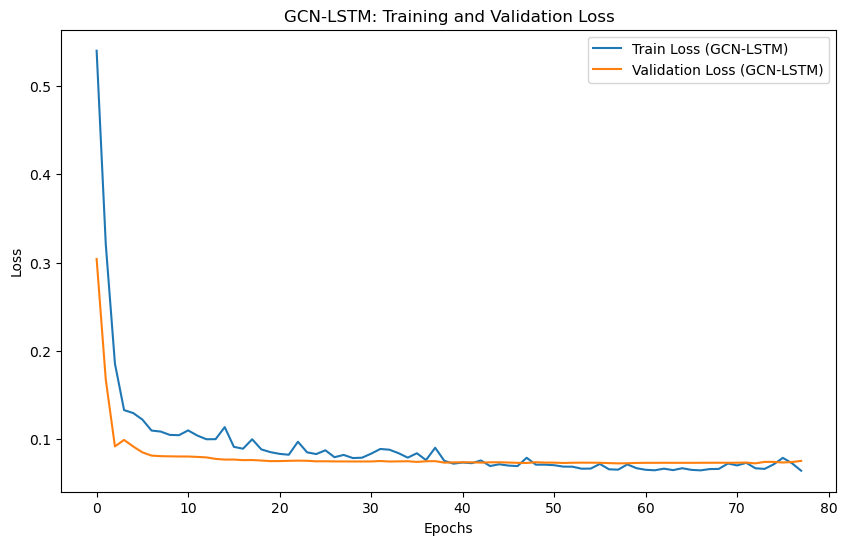

Evaluating GCN-LSTM...
Station 57 Actuals (first 10): [4542.167 4542.167 4542.167 4542.167 4542.167 4542.167 4542.167 4542.167
 4542.167 4542.167]
Station 57 Preds (first 10): [4723.67 4723.67 4723.67 4723.67 4723.67 4723.67 4723.67 4723.67 4723.67
 4723.67]
Station 57 Variance: 9.5367431640625e-07
GCN-LSTM Test MAE: 1.4138
GCN-LSTM Test RMSE: 3.3166
GCN-LSTM Test rRMSE: 0.0002
GCN-LSTM Test MAPE: 10.8700%


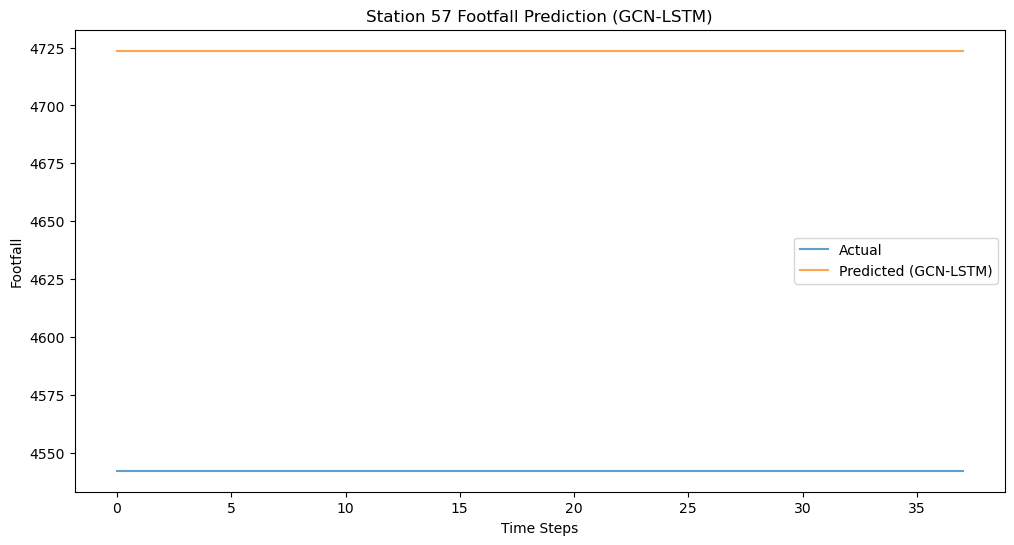

In [10]:
class ImprovedPureLSTM(nn.Module):
    def __init__(self, num_nodes, input_dim, hidden_dim, output_dim, dropout=0.2, emb_dim=16):
        super(ImprovedPureLSTM, self).__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        
        # Station Embedding
        self.node_emb = nn.Embedding(num_nodes, emb_dim)
        
        # LSTM
        # Input dimension is original features + embedding dimension
        self.lstm = nn.LSTM(input_dim + emb_dim, hidden_dim, batch_first=True, num_layers=1, dropout=dropout)
        
        # Layer Norm
        self.ln = nn.LayerNorm(hidden_dim)
        
        # Output head
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, adj=None):
        # x shape: (Batch, Time, Nodes, Features)
        B, T, N, F = x.shape
        
        # 1. Prepare Node Embeddings
        node_indices = torch.arange(N, device=x.device).unsqueeze(0).unsqueeze(0) # (1, 1, N)
        node_indices = node_indices.expand(B, T, N)
        embeddings = self.node_emb(node_indices)
        
        # 2. Concatenate Features and Embeddings
        x_cat = torch.cat([x, embeddings], dim=-1)
        
        # 3. Reshape for LSTM (Batch * Nodes, Time, Feat_Cat)
        x_reshaped = x_cat.permute(0, 2, 1, 3).contiguous().view(B * N, T, F + self.emb_dim)
        
        # 4. LSTM Forward
        lstm_out, _ = self.lstm(x_reshaped)
        
        # 5. Take last time step
        last_step_out = lstm_out[:, -1, :] # (B*N, H)
        
        # 6. Layer Norm & Dropout & FC
        out = self.ln(last_step_out)
        out = self.fc(self.dropout(out)) # (B*N, 1)
        
        # 7. Reshape back to (B, N)
        out = out.view(B, N)
        
        return out

# Instantiate the improved baseline model with simpler config
# Reduced hidden_dim to 64 and num_layers to 1
improved_baseline_model = ImprovedPureLSTM(num_nodes=num_stations, input_dim=1, hidden_dim=64, output_dim=1, dropout=0.1, emb_dim=16).to(DEVICE)
print("GCN-LSTM Model defined (Simpler Config):")
print(improved_baseline_model)

# Redefine train_model to accept a save path
def train_model_custom(model, train_loader, val_loader, adj, epochs=100, patience=20, save_path='best_model.pth'):
    criterion = nn.HuberLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data, adj)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data, adj)
                loss = criterion(output, target)
                val_loss += loss.item()
                
        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)
        
        scheduler.step(epoch + val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break
                
    return history

# Train the baseline model
print("\nStarting training for GCN-LSTM...")
save_path = 'best_improved_pure_lstm_model.pth'
history_improved_baseline = train_model_custom(improved_baseline_model, train_loader, val_loader, None, epochs=100, patience=20, save_path=save_path)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history_improved_baseline['train_loss'], label='Train Loss (GCN-LSTM)')
plt.plot(history_improved_baseline['val_loss'], label='Validation Loss (GCN-LSTM)')
plt.title('GCN-LSTM: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the baseline model
print("Evaluating GCN-LSTM...")
improved_baseline_model.load_state_dict(torch.load(save_path)) 

# Use the custom evaluate_model which handles adj=None
if 'evaluate_model' in locals():
    mae_ibl, rmse_ibl, rrmse_ibl, mape_ibl, preds_ibl, actuals_ibl = evaluate_model(improved_baseline_model, test_loader, None, scaler)

    print(f"GCN-LSTM Test MAE: {mae_ibl:.4f}")
    print(f"GCN-LSTM Test RMSE: {rmse_ibl:.4f}")
    print(f"GCN-LSTM Test rRMSE: {rrmse_ibl:.4f}")
    print(f"GCN-LSTM Test MAPE: {mape_ibl:.4f}%")
else:
    print("evaluate_model function not found. Please run the cell defining it.")

# Visualize Station 57 for Improved Baseline
st_idx = 57
plt.figure(figsize=(12, 6))
plt.plot(actuals_ibl[:, st_idx], label='Actual', alpha=0.7)
plt.plot(preds_ibl[:, st_idx], label='Predicted (GCN-LSTM)', alpha=0.7)
plt.title(f'Station {st_idx} Footfall Prediction (GCN-LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('Footfall')
plt.legend()
plt.show()

Using device: cpu
Loading transport data...
Resampling to weekly average...
Final processed transport data shape: (261, 387)

Loading and processing external feature matrix...
Aligned Feature Matrix shape: (387, 15)
External Feature Adjacency Matrix created and normalized.
Starting training for Improved Pure LSTM Baseline...
Epoch 10/100 | Train: 0.38143 | Val: 0.34970
Epoch 20/100 | Train: 0.23878 | Val: 0.41294
Early stopping.


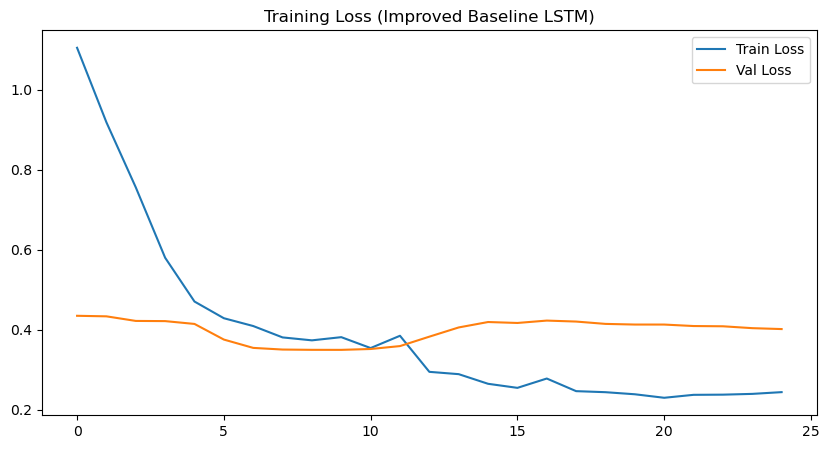

Evaluating Improved Baseline Pure LSTM...
Improved Baseline Test MAE: 2.4210
Improved Baseline Test RMSE: 5.1989
Improved Baseline Test rRMSE: 0.0003
Improved Baseline Test MAPE: 13.4586%


In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from geopy.distance import geodesic
import warnings

# ==========================================
# 1. Configuration & Setup
# ==========================================
SEED = 42
WINDOW_SIZE = 12
PREDICT_AHEAD = 1
BATCH_SIZE = 32
EPOCHS = 100
PATIENCE = 15
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

warnings.filterwarnings('ignore')
print(f"Using device: {DEVICE}")

# ==========================================
# 2. Data Loading & Preprocessing (Transport)
# ==========================================
# Update these paths to your actual file locations
transport_data_path = '/Users/goffy/Desktop/CASA0004/ex3_transport/merged_transport_data_wide.csv'
feature_data_path = '/Users/goffy/Desktop/CASA0004/data&preprocessing/gcn_feature_matrix_custom_spatial_imputed_scaled.csv'

print("Loading transport data...")
df = pd.read_csv(transport_data_path)

# Extract coordinates
station_coords = df[['Station', 'latitude', 'longitude']].copy()
station_coords = station_coords.set_index('Station')

# Prepare time series data
ts_data = df.drop(columns=['latitude', 'longitude'])
ts_data = ts_data.set_index('Station')
ts_data = ts_data.T
ts_data.index = pd.to_datetime(ts_data.index)
ts_data = ts_data.sort_index()

# Replace 0 with NaN and resample
ts_data = ts_data.replace(0, np.nan)
print("Resampling to weekly average...")
ts_data = ts_data.resample('W').mean()

# --- Data Cleaning (Outliers) ---
# 1. Remove High Missing Values
missing_pct = ts_data.isna().sum() / len(ts_data)
threshold = 0.25
stations_to_keep = missing_pct[missing_pct <= threshold].index
ts_data = ts_data[stations_to_keep]
station_coords = station_coords.loc[stations_to_keep]

# 2. Remove Spatial Outliers (IQR)
lat = station_coords['latitude']
lon = station_coords['longitude']
Q1_lat, Q3_lat = lat.quantile(0.25), lat.quantile(0.75)
IQR_lat = Q3_lat - Q1_lat
lat_lower, lat_upper = Q1_lat - 1.5 * IQR_lat, Q3_lat + 1.5 * IQR_lat
Q1_lon, Q3_lon = lon.quantile(0.25), lon.quantile(0.75)
IQR_lon = Q3_lon - Q1_lon
lon_lower, lon_upper = Q1_lon - 1.5 * IQR_lon, Q3_lon + 1.5 * IQR_lon

spatial_mask = (
    (lat >= lat_lower) & (lat <= lat_upper) &
    (lon >= lon_lower) & (lon <= lon_upper)
)
stations_spatial_keep = station_coords[spatial_mask].index
ts_data = ts_data[stations_spatial_keep]
station_coords = station_coords.loc[stations_spatial_keep]

# 3. Remove Low Volume Outliers
avg_footfall = ts_data.mean()
vol_lower = avg_footfall.quantile(0.01)
stations_vol_keep = avg_footfall[avg_footfall > vol_lower].index
ts_data = ts_data[stations_vol_keep]
station_coords = station_coords.loc[stations_vol_keep]

# Clip extreme values
ts_data = ts_data.clip(upper=ts_data.quantile(0.999), axis=1)

# Impute missing values
ts_data = ts_data.interpolate(method='linear', limit_direction='both').fillna(0)

# Normalize Footfall
scaler = StandardScaler()
ts_data[:] = scaler.fit_transform(ts_data)

print(f"Final processed transport data shape: {ts_data.shape}")
stations = ts_data.columns.tolist() # The final list of stations we are training on
num_stations = len(stations)

# Convert to tensor
data_tensor = torch.FloatTensor(ts_data.values)

# ==========================================
# 3. External Feature Matrix Processing
# ==========================================
print("\nLoading and processing external feature matrix...")
feature_df = pd.read_csv(feature_data_path)

# --- Alignment Step ---
# We need to make sure the rows in the feature matrix correspond EXACTLY 
# to the columns in ts_data (stations).
# We assume 'LSOA_CODE' in feature_df matches 'Station' in ts_data.

# Filter feature_df to only include the stations we kept
# (Assuming 'LSOA_CODE' is the identifier column in the CSV)
if 'LSOA_CODE' in feature_df.columns:
    feature_df = feature_df.set_index('LSOA_CODE')
    
    # Check intersection
    common_stations = [st for st in stations if st in feature_df.index]
    if len(common_stations) < len(stations):
        print(f"Warning: Only {len(common_stations)} out of {len(stations)} stations found in feature CSV.")
        # For this demo, if missing, we might need to handle differently.
        # Here we re-index to force alignment, filling missing with 0 (or mean)
        feature_df = feature_df.reindex(stations).fillna(0)
    else:
        feature_df = feature_df.loc[stations]
else:
    print("Warning: 'LSOA_CODE' column not found. Attempting simple row truncation/alignment.")
    # Fallback: Just take the first N rows if they match logically
    feature_df = feature_df.iloc[:num_stations]

# Select numerical columns for similarity calculation
# Exclude non-numeric or ID columns
numeric_cols = feature_df.select_dtypes(include=[np.number]).columns
feature_matrix = feature_df[numeric_cols].values

print(f"Aligned Feature Matrix shape: {feature_matrix.shape}")

# Calculate Cosine Similarity
sim_matrix = cosine_similarity(feature_matrix)
# Remove negative correlations (optional, but standard for GCN adjacency)
sim_matrix[sim_matrix < 0] = 0 

# Thresholding to create sparse graph (reduce noise)
adj_threshold = 0.5
adj_feature = np.copy(sim_matrix)
adj_feature[adj_feature < adj_threshold] = 0

# Add self-loops
np.fill_diagonal(adj_feature, 1)

def process_adj_matrix(adj):
    """Row-normalize the adjacency matrix."""
    rowsum = np.array(adj.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = np.diag(r_inv)
    normalized_adj = r_mat_inv.dot(adj)
    return normalized_adj

# Normalize
A_hat_feature = process_adj_matrix(adj_feature)
print("External Feature Adjacency Matrix created and normalized.")

# ==========================================
# 4. Dataset & DataLoader
# ==========================================
class TransportDataset(Dataset):
    def __init__(self, data_tensor, window_size, predict_ahead=1):
        self.data = data_tensor
        self.window_size = window_size
        self.predict_ahead = predict_ahead
        self.num_samples = len(data_tensor) - window_size - predict_ahead + 1
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        X = self.data[idx : idx + self.window_size]
        X = X.unsqueeze(-1) # Add feature dim: (Window, Nodes, 1)
        y = self.data[idx + self.window_size + self.predict_ahead - 1]
        return X, y

full_dataset = TransportDataset(data_tensor, WINDOW_SIZE, PREDICT_AHEAD)

total_samples = len(full_dataset)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

indices = list(range(total_samples))
train_dataset = Subset(full_dataset, indices[:train_size])
val_dataset = Subset(full_dataset, indices[train_size:train_size+val_size])
test_dataset = Subset(full_dataset, indices[train_size+val_size:])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ==========================================
# 5. Model Definition (GCN-LSTM)
# ==========================================
class GraphConvLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.2):
        super(GraphConvLayer, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.xavier_uniform_(self.weight)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, adj):
        # x: (Batch * Time, Nodes, Features)
        support = torch.matmul(x, self.weight)
        output = torch.matmul(adj, support)
        return self.dropout(output)

class TemporalAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(TemporalAttention, self).__init__()
        self.W_q = nn.Linear(hidden_dim, hidden_dim)
        self.W_v = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        scores = self.W_v(torch.tanh(self.W_q(x))) 
        weights = F.softmax(scores, dim=1)
        context = torch.sum(x * weights, dim=1)
        return context, weights

class GCN_LSTM_Attn(nn.Module):
    def __init__(self, num_nodes, input_dim, hidden_dim, output_dim, dropout=0.2):
        super(GCN_LSTM_Attn, self).__init__()
        self.gcn = GraphConvLayer(input_dim, hidden_dim, dropout)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.attention = TemporalAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.hidden_dim = hidden_dim

    def forward(self, x, adj):
        B, T, N, F = x.shape
        x_gcn_in = x.view(B * T, N, F)
        x_gcn_out = self.relu(self.gcn(x_gcn_in, adj))
        
        x_reshaped = x_gcn_out.view(B, T, N, self.hidden_dim)
        x_permuted = x_reshaped.permute(0, 2, 1, 3) # (B, N, T, H)
        x_lstm_in = x_permuted.reshape(B * N, T, self.hidden_dim)
        
        lstm_out, _ = self.lstm(x_lstm_in)
        context, _ = self.attention(lstm_out)
        
        out = self.fc(self.dropout(context))
        out = out.view(B, N)
        return out

# Initialize Model
model = GCN_LSTM_Attn(num_nodes=num_stations, input_dim=1, hidden_dim=64, output_dim=1).to(DEVICE)

# ==========================================
# 6. Training & Evaluation
# ==========================================
def train_model(model, train_loader, val_loader, adj, epochs=50, patience=10):
    criterion = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    
    best_val_loss = float('inf')
    patience_counter = 0
    adj = torch.FloatTensor(adj).to(DEVICE)
    
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_x, adj)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_losses.append(loss.item())
            
        avg_train_loss = np.mean(train_losses)
        
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
                outputs = model(batch_x, adj)
                val_losses.append(criterion(outputs, batch_y).item())
                
        avg_val_loss = np.mean(val_losses)
        scheduler.step()
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train: {avg_train_loss:.5f} | Val: {avg_val_loss:.5f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_feature_gcn_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break
    return history

def evaluate_model(model, test_loader, adj, scaler):
    model.eval()
    preds, actuals = [], []
    adj = torch.FloatTensor(adj).to(DEVICE)
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(DEVICE)
            outputs = model(batch_x, adj)
            preds.append(outputs.cpu().numpy())
            actuals.append(batch_y.numpy())
            
    preds = np.concatenate(preds, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    
    # Inverse transform
    preds_inv = scaler.inverse_transform(preds)
    actuals_inv = scaler.inverse_transform(actuals)
    
    mse_temp = mean_squared_error(actuals_inv, preds_inv)

    epsilon = 1e-10
    mape = np.mean(np.abs((actuals_inv - preds_inv) / (actuals_inv + epsilon))) * 100

    mae = mean_absolute_error(actuals_inv, preds_inv)/1000
    

    rmse = np.sqrt(mse_temp)/1000
    rrmse = rmse / np.mean(actuals_inv)
    
    
    return mae, rmse, rrmse, mape, preds_inv, actuals_inv

# Train
print("Starting training for Improved Pure LSTM Baseline...")
history = train_model(model, train_loader, val_loader, A_hat_feature, epochs=EPOCHS, patience=PATIENCE)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training Loss (Improved Baseline LSTM)')
plt.legend()
plt.show()

# Evaluate
print("Evaluating Improved Baseline Pure LSTM...")
model.load_state_dict(torch.load('best_feature_gcn_model.pth'))
mae, rmse, rrmse, mape, preds, actuals = evaluate_model(model, test_loader, A_hat_feature, scaler)

print(f"Improved Baseline Test MAE: {mae:.4f}")
print(f"Improved Baseline Test RMSE: {rmse:.4f}")
print(f"Improved Baseline Test rRMSE: {rrmse:.4f}")
print(f"Improved Baseline Test MAPE: {mape:.4f}%")

In [12]:
# ==========================================
# 7. Summary of Evaluation Metrics
# ==========================================
print("\nSummary of Evaluation Metrics:")

metrics_data = {
    'Model': [],
    'MAE': [],
    'RMSE': [],
    'rRMSE': [],
    'MAPE (%)': []
}

# Helper to add row
def add_metrics(name, mae_val, rmse_val, rrmse_val, mape_val):
    metrics_data['Model'].append(name)
    metrics_data['MAE'].append(mae_val)
    metrics_data['RMSE'].append(rmse_val)
    metrics_data['rRMSE'].append(rrmse_val)
    metrics_data['MAPE (%)'].append(mape_val)

# Add Feature-based GCN (Current 'model')
# Note: If you ran the Weighted Graph GCN last, these values correspond to that.
# Based on the cell order, the last one run was likely the Feature-based GCN.
if 'mae' in locals():
    add_metrics('Pure LSTM', mae, rmse, rrmse, mape)

# Add TFT
if 'mae_tft' in locals():
    add_metrics('TFT Baseline', mae_tft, rmse_tft, rrmse_tft, mape_tft)

# Add Pure LSTM
if 'mae_bl' in locals():
    add_metrics('LSTM MMD', mae_bl, rmse_bl, rrmse_bl, mape_bl)

# Add Improved Pure LSTM
if 'mae_ibl' in locals():
    add_metrics('GCN-LSTM (Feature/Weighted)', mae_ibl, rmse_ibl, rrmse_ibl, mape_ibl)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.set_index('Model')

# Display
print(metrics_df)


Summary of Evaluation Metrics:
                                  MAE      RMSE     rRMSE   MAPE (%)
Model                                                               
Pure LSTM                    2.421015  5.198896  0.000282  13.458567
TFT Baseline                 1.603492  3.750162  0.000203  11.442741
LSTM MMD                     1.717127  3.937252  0.000213  13.676417
GCN-LSTM (Feature/Weighted)  1.413764  3.316629  0.000180  10.869978
